## Fast Bayesian estimation of SARIMAX models pymc3

In [1]:
%load_ext lab_black

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
import statsmodels.api as sm
import theano
import theano.tensor as tt
from pandas.plotting import register_matplotlib_converters
from pandas_datareader.data import DataReader

plt.style.use("seaborn")
register_matplotlib_converters()

WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.
WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [3]:
cpi = DataReader("CPIAUCNS", "fred", start="1971-01", end="2018-12")
cpi.index = pd.DatetimeIndex(cpi.index, freq="MS")

# Define the inflation series that we'll use in analysis
inf = np.log(cpi).resample("QS").mean().diff()[1:] * 400
inf = inf.dropna()
print(inf.head())

            CPIAUCNS
DATE                
1971-04-01  4.316424
1971-07-01  4.279518
1971-10-01  1.956799
1972-01-01  2.917767
1972-04-01  3.219096


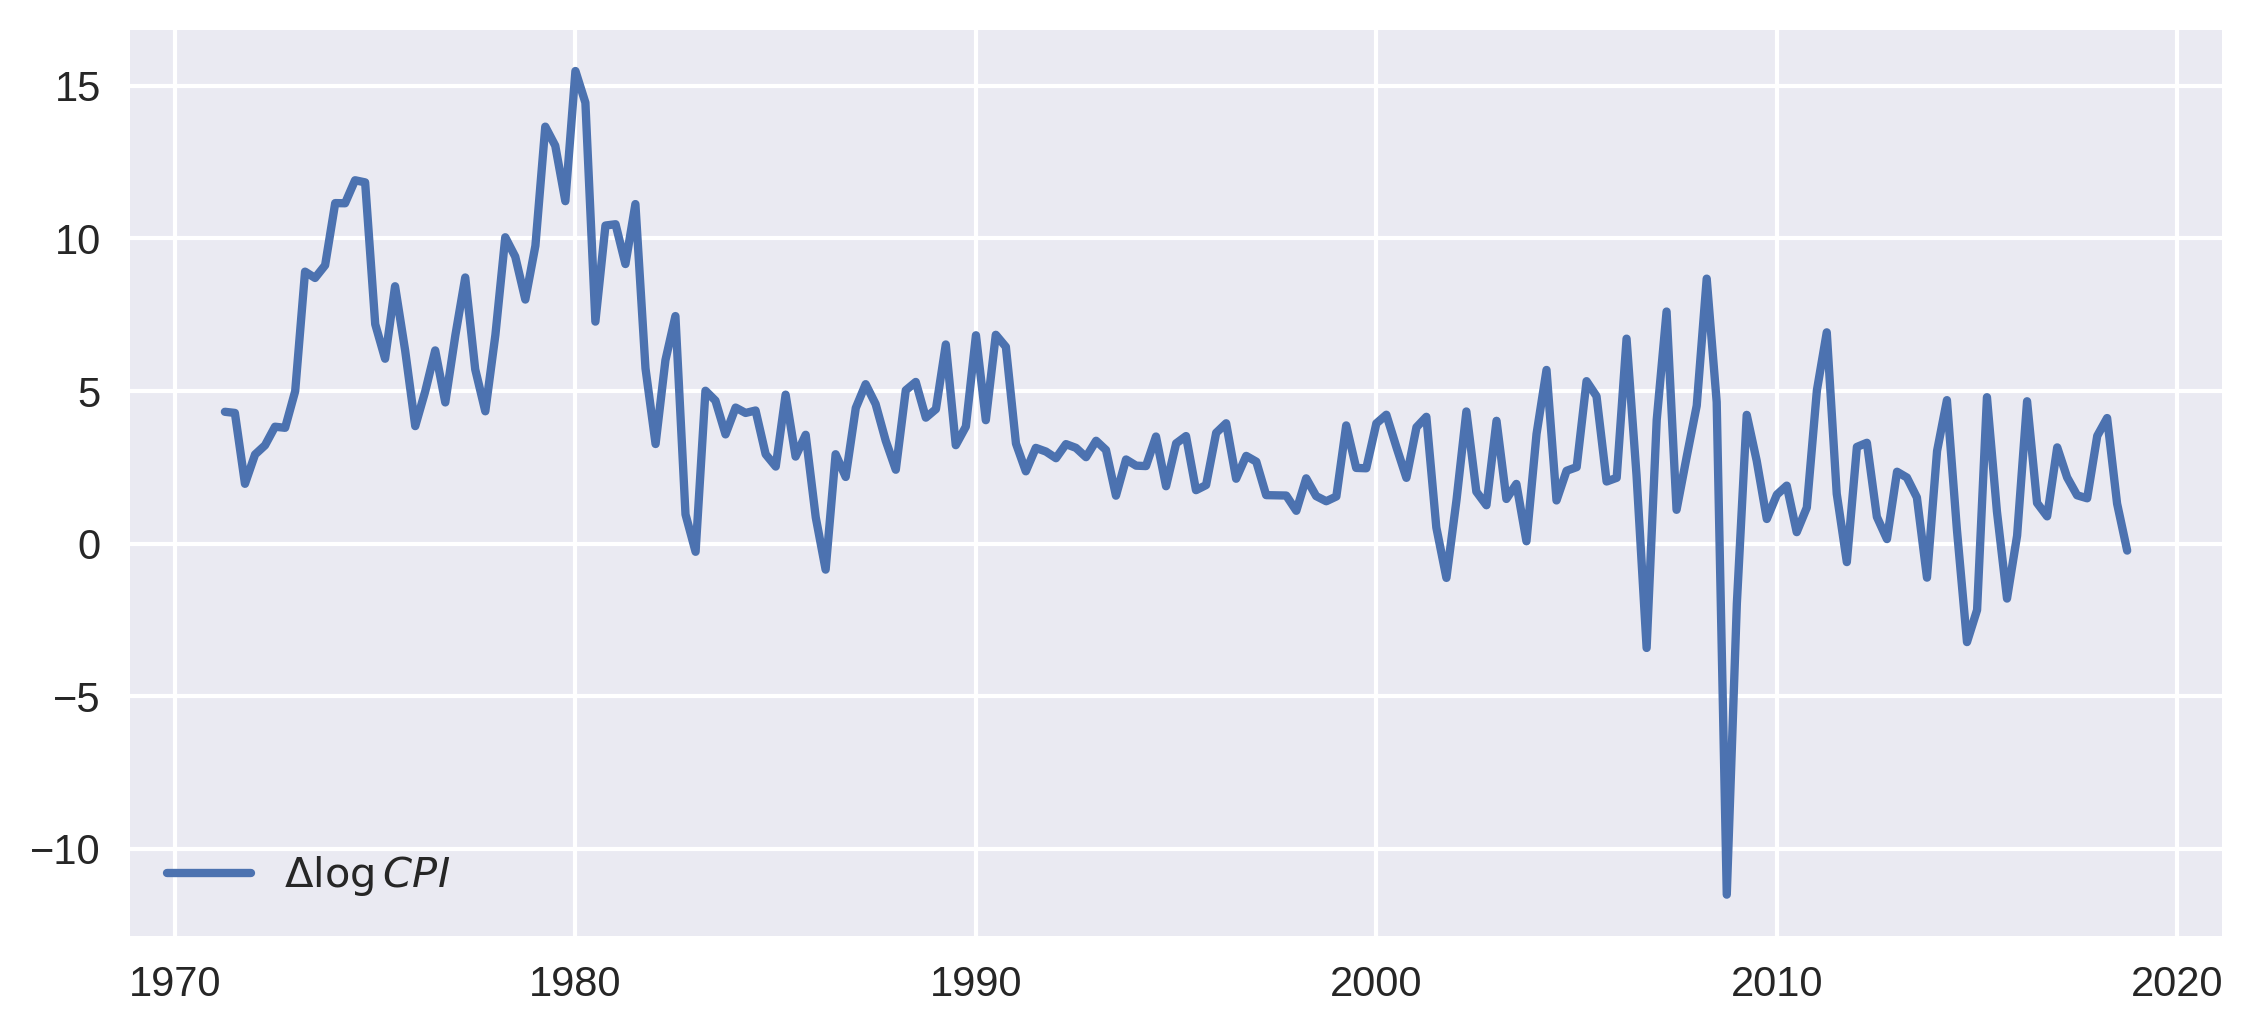

In [4]:
# Plot the series
fig, ax = plt.subplots(figsize=(9, 4), dpi=300)
ax.plot(inf.index, inf, label=r"$\Delta \log CPI$", lw=2)
ax.legend(loc="lower left")
plt.show()

In [5]:
# Create an SARIMAX model instance - here we use it to estimate
# the parameters via MLE using the `fit` method, but we can
# also re-use it below for the Bayesian estimation
mod = sm.tsa.statespace.SARIMAX(inf, order=(1, 0, 1))

res_mle = mod.fit(disp=False)
print(res_mle.summary())

                               SARIMAX Results                                
Dep. Variable:               CPIAUCNS   No. Observations:                  191
Model:               SARIMAX(1, 0, 1)   Log Likelihood                -448.685
Date:                Wed, 28 Jul 2021   AIC                            903.370
Time:                        12:14:42   BIC                            913.127
Sample:                    04-01-1971   HQIC                           907.322
                         - 10-01-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9785      0.015     64.545      0.000       0.949       1.008
ma.L1         -0.6342      0.057    -11.073      0.000      -0.747      -0.522
sigma2         6.3682      0.323     19.695      0.0

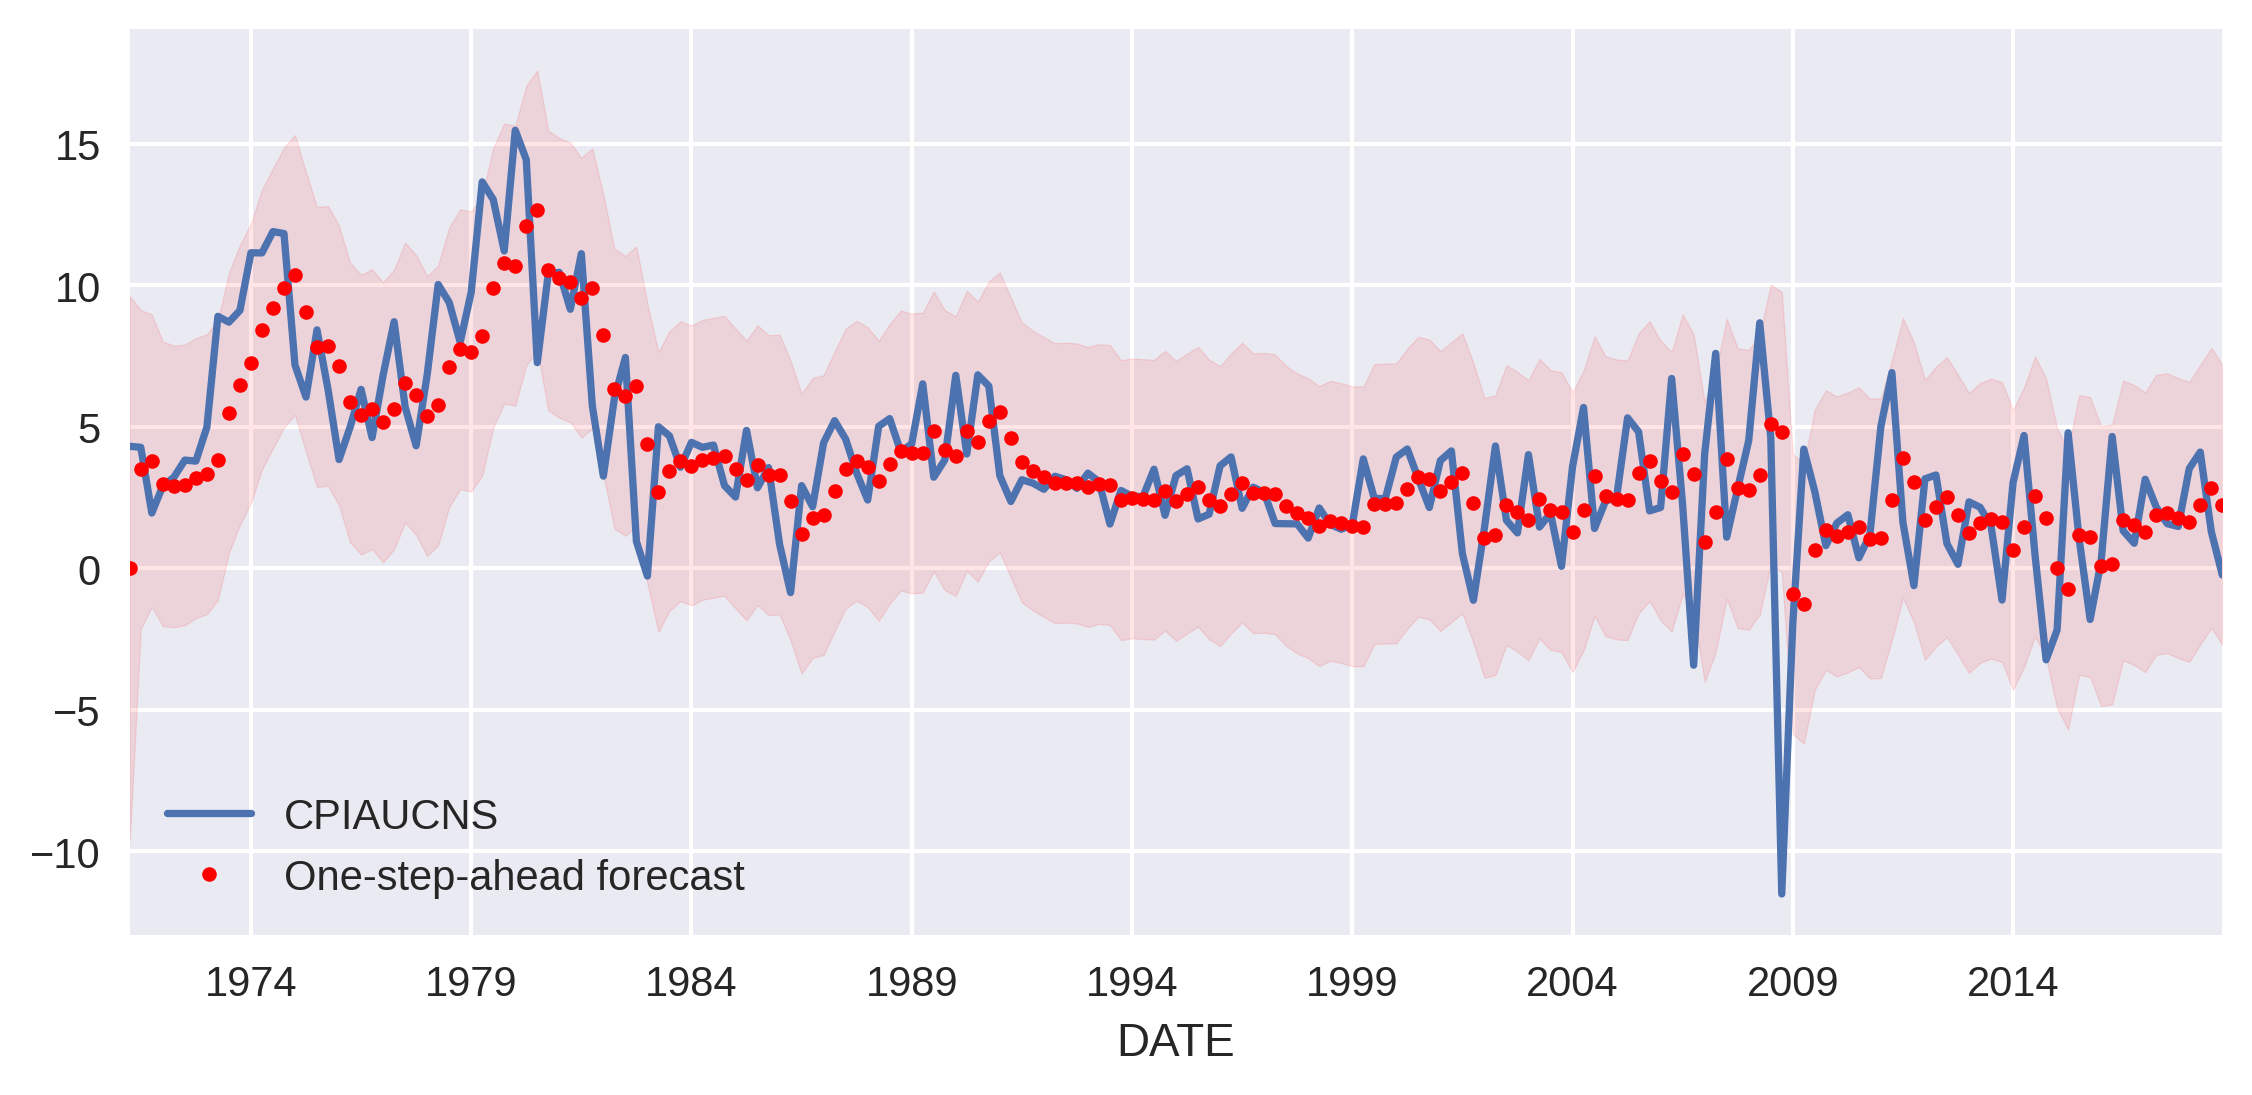

In [6]:
predict_mle = res_mle.get_prediction()
predict_mle_ci = predict_mle.conf_int()
lower = predict_mle_ci["lower CPIAUCNS"]
upper = predict_mle_ci["upper CPIAUCNS"]

# Graph
fig, ax = plt.subplots(figsize=(9, 4), dpi=300)

# Plot data points
inf.plot(ax=ax, style="-", label="Observed")

# Plot predictions
predict_mle.predicted_mean.plot(ax=ax, style="r.", label="One-step-ahead forecast")
ax.fill_between(predict_mle_ci.index, lower, upper, color="r", alpha=0.1)
ax.legend(loc="lower left")
plt.show()

In [7]:
class Loglike(tt.Op):

    itypes = [tt.dvector]  # expects a vector of parameter values when called
    otypes = [tt.dscalar]  # outputs a single scalar value (the log likelihood)

    def __init__(self, model):
        self.model = model
        self.score = Score(self.model)

    def perform(self, node, inputs, outputs):
        (theta,) = inputs  # contains the vector of parameters
        llf = self.model.loglike(theta)
        outputs[0][0] = np.array(llf)  # output the log-likelihood

    def grad(self, inputs, g):
        # the method that calculates the gradients - it actually returns the
        # vector-Jacobian product - g[0] is a vector of parameter values
        (theta,) = inputs  # our parameters
        out = [g[0] * self.score(theta)]
        return out


class Score(tt.Op):
    itypes = [tt.dvector]
    otypes = [tt.dvector]

    def __init__(self, model):
        self.model = model

    def perform(self, node, inputs, outputs):
        (theta,) = inputs
        outputs[0][0] = self.model.score(theta)

In [8]:
# Set sampling params
ndraws = 3000  # number of draws from the distribution
nburn = 600  # number of "burn-in points" (which will be discarded)

In [9]:
# Construct an instance of the Theano wrapper defined above, which
# will allow PyMC3 to compute the likelihood and Jacobian in a way
# that it can make use of. Here we are using the same model instance
# created earlier for MLE analysis (we could also create a new model
# instance if we preferred)
loglike = Loglike(mod)

with pm.Model() as m:
    # Priors
    arL1 = pm.Uniform("ar.L1", -0.99, 0.99)
    maL1 = pm.Uniform("ma.L1", -0.99, 0.99)
    sigma2 = pm.InverseGamma("sigma2", 2, 4)

    # convert variables to tensor vectors
    theta = tt.as_tensor_variable([arL1, maL1, sigma2])

    # use a DensityDist (use a lamdba function to "call" the Op)
    pm.DensityDist("likelihood", loglike, observed=theta)

    # Draw samples
    trace = pm.sample(
        ndraws,
        tune=nburn,
        return_inferencedata=True,
        cores=1,
        compute_convergence_checks=False,
    )

/opt/conda/lib/python3.9/site-packages/theano/tensor/elemwise.py:826: RuntimeWarning: divide by zero encountered in true_divide
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sigma2, ma.L1, ar.L1]


Sampling 2 chains for 600 tune and 3_000 draw iterations (1_200 + 6_000 draws total) took 699 seconds.
There were 28 divergences after tuning. Increase `target_accept` or reparameterize.


<Figure size 576x396 with 0 Axes>

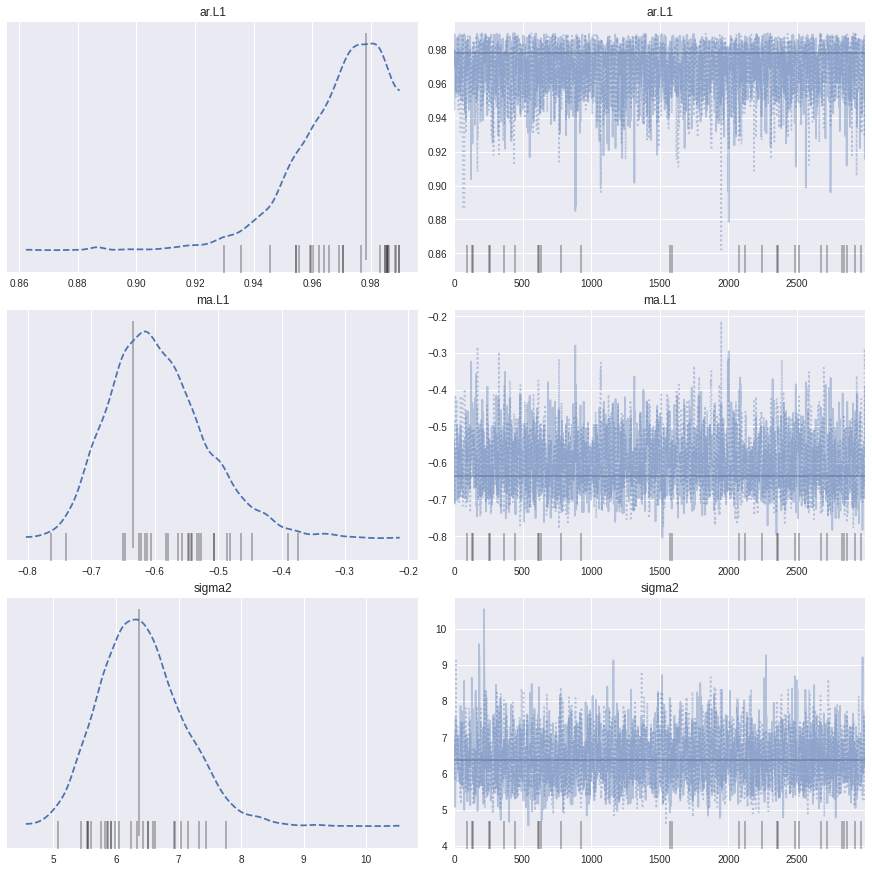

In [10]:
plt.tight_layout()
# Note: the syntax here for the lines argument is required for
# PyMC3 versions >= 3.7
# For version <= 3.6 you can use lines=dict(res_mle.params) instead
_ = pm.plot_trace(
    trace,
    lines=[(k, {}, [v]) for k, v in dict(res_mle.params).items()],
    combined=True,
    figsize=(12, 12),
)

In [11]:
pm.summary(trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
ar.L1,0.969,0.015,0.943,0.990,0.000,0.000,1903.0,2008.0,1.0
ma.L1,-0.595,0.077,-0.736,-0.456,0.002,0.001,2274.0,1819.0,1.0
sigma2,6.417,0.675,5.215,7.675,0.014,0.010,2526.0,2841.0,1.0


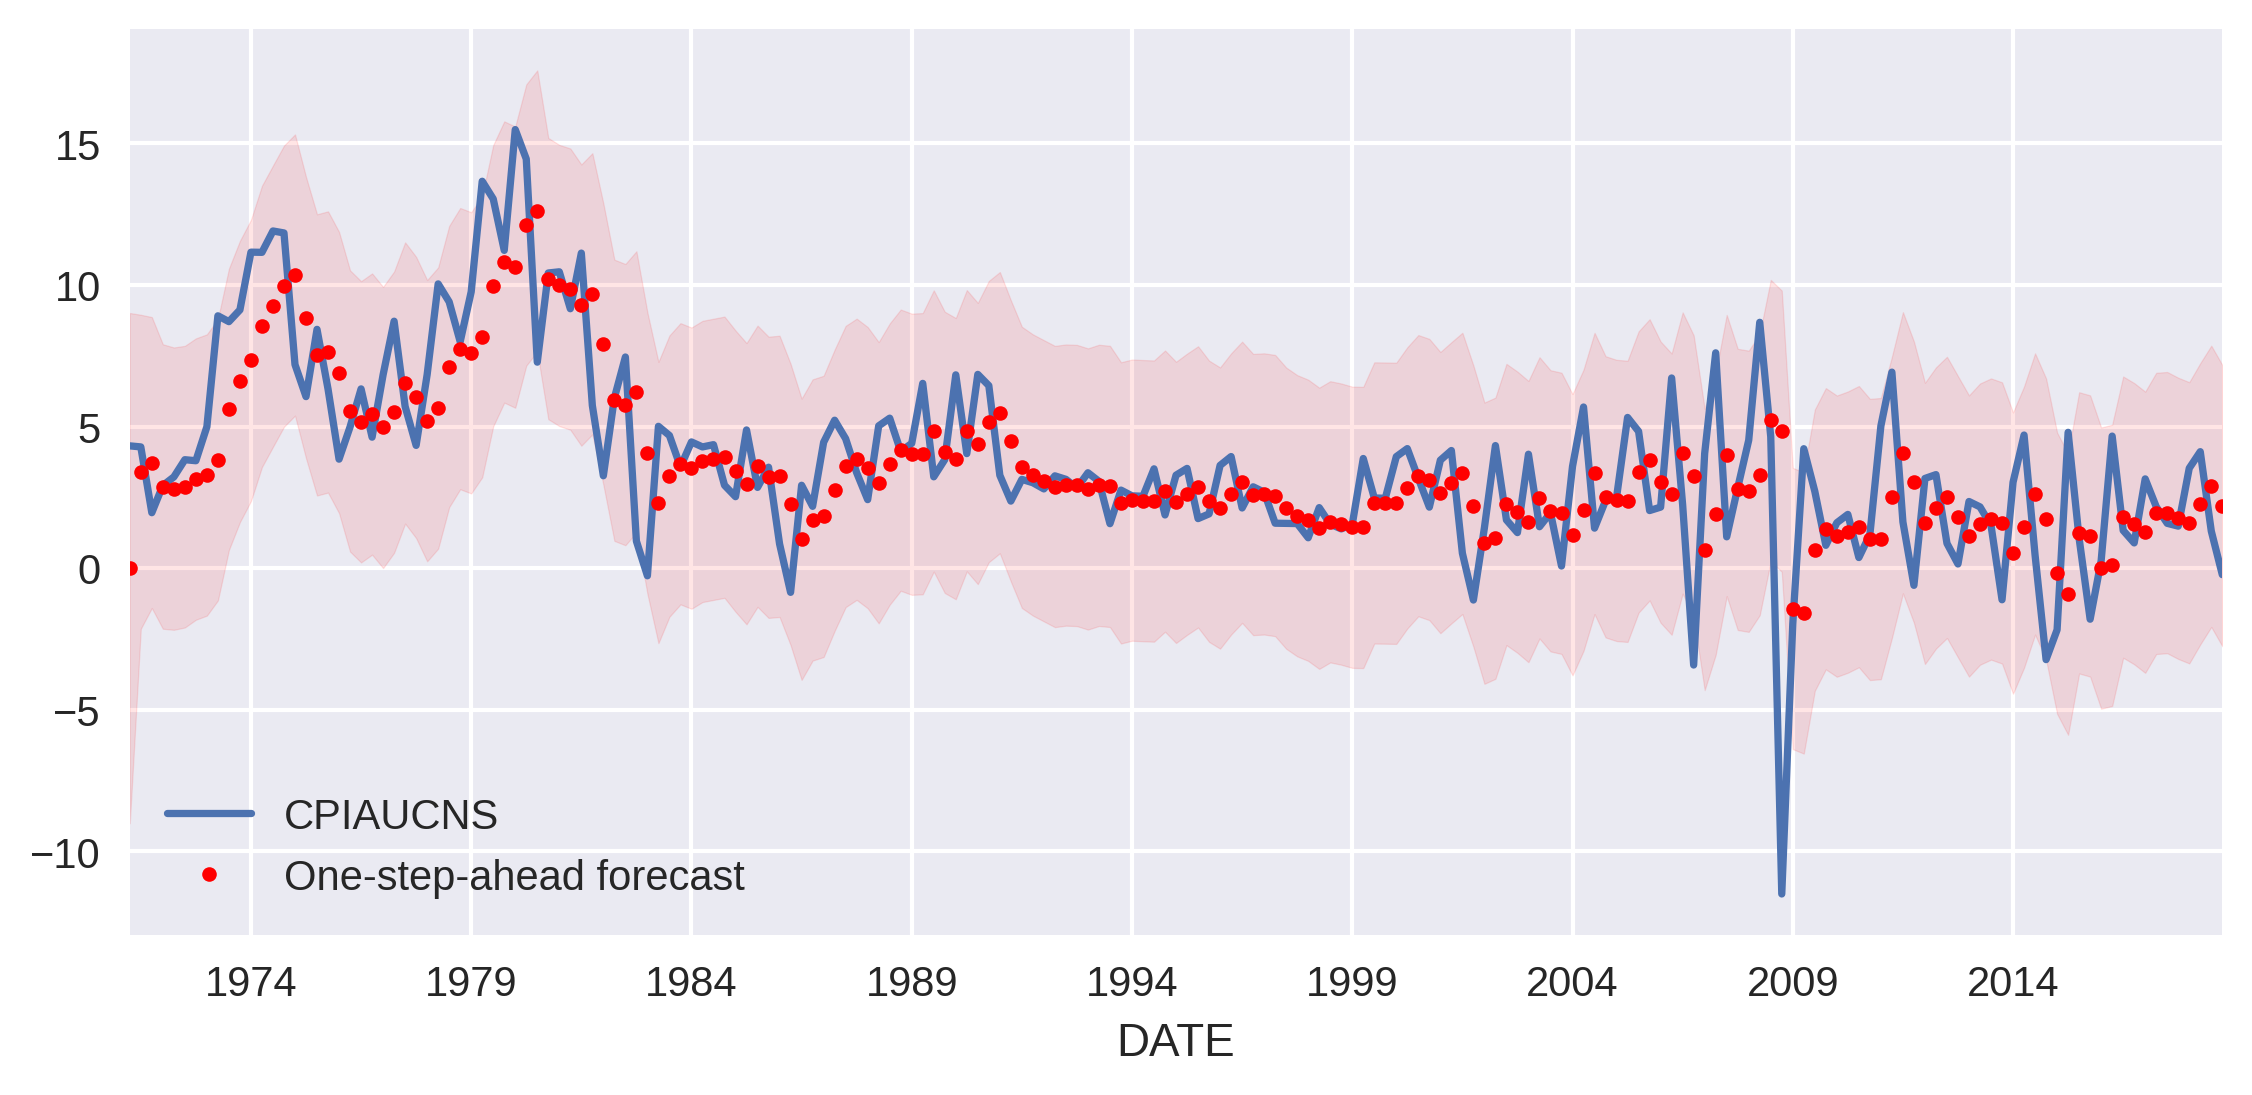

In [12]:
# Retrieve the posterior means
params = pm.summary(trace)["mean"].values

# Construct results using these posterior means as parameter values
res_bayes = mod.smooth(params)

predict_bayes = res_bayes.get_prediction()
predict_bayes_ci = predict_bayes.conf_int()
lower = predict_bayes_ci["lower CPIAUCNS"]
upper = predict_bayes_ci["upper CPIAUCNS"]

# Graph
fig, ax = plt.subplots(figsize=(9, 4), dpi=300)

# Plot data points
inf.plot(ax=ax, style="-", label="Observed")

# Plot predictions
predict_bayes.predicted_mean.plot(ax=ax, style="r.", label="One-step-ahead forecast")
ax.fill_between(predict_bayes_ci.index, lower, upper, color="r", alpha=0.1)
ax.legend(loc="lower left")
plt.show()

In [13]:
# Construct the model instance
mod_uc = sm.tsa.UnobservedComponents(inf, "rwalk", autoregressive=1)

# Fit the model via maximum likelihood
res_uc_mle = mod_uc.fit()
print(res_uc_mle.summary())

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.43820D+00    |proj g|=  1.07332D-01

At iterate    5    f=  2.31427D+00    |proj g|=  2.20639D-02

At iterate   10    f=  2.30814D+00    |proj g|=  1.67048D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     11     14      1     0     0   7.394D-08   2.308D+00
  F =   2.3081388933012654     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
                        Unobserved Components Results                 

 This problem is unconstrained.


In [14]:
# Set sampling params
ndraws = 3000  # number of draws from the distribution
nburn = 600  # number of "burn-in points" (which will be discarded)

In [15]:
# Here we follow the same procedure as above, but now we instantiate the
# Theano wrapper `Loglike` with the UC model instance instead of the
# SARIMAX model instance
loglike_uc = Loglike(mod_uc)

with pm.Model():
    # Priors
    sigma2level = pm.InverseGamma("sigma2.level", 1, 1)
    sigma2ar = pm.InverseGamma("sigma2.ar", 1, 1)
    arL1 = pm.Uniform("ar.L1", -0.99, 0.99)

    # convert variables to tensor vectors
    theta_uc = tt.as_tensor_variable([sigma2level, sigma2ar, arL1])

    # use a DensityDist (use a lamdba function to "call" the Op)
    pm.DensityDist("likelihood", loglike_uc, observed=theta_uc)

    # Draw samples
    trace_uc = pm.sample(
        ndraws,
        tune=nburn,
        return_inferencedata=True,
        cores=1,
        compute_convergence_checks=False,
    )

/opt/conda/lib/python3.9/site-packages/theano/tensor/elemwise.py:826: RuntimeWarning: divide by zero encountered in true_divide
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
/opt/conda/lib/python3.9/site-packages/theano/tensor/elemwise.py:826: RuntimeWarning: invalid value encountered in multiply
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [ar.L1, sigma2.ar, sigma2.level]


Sampling 2 chains for 600 tune and 3_000 draw iterations (1_200 + 6_000 draws total) took 456 seconds.


<Figure size 576x396 with 0 Axes>

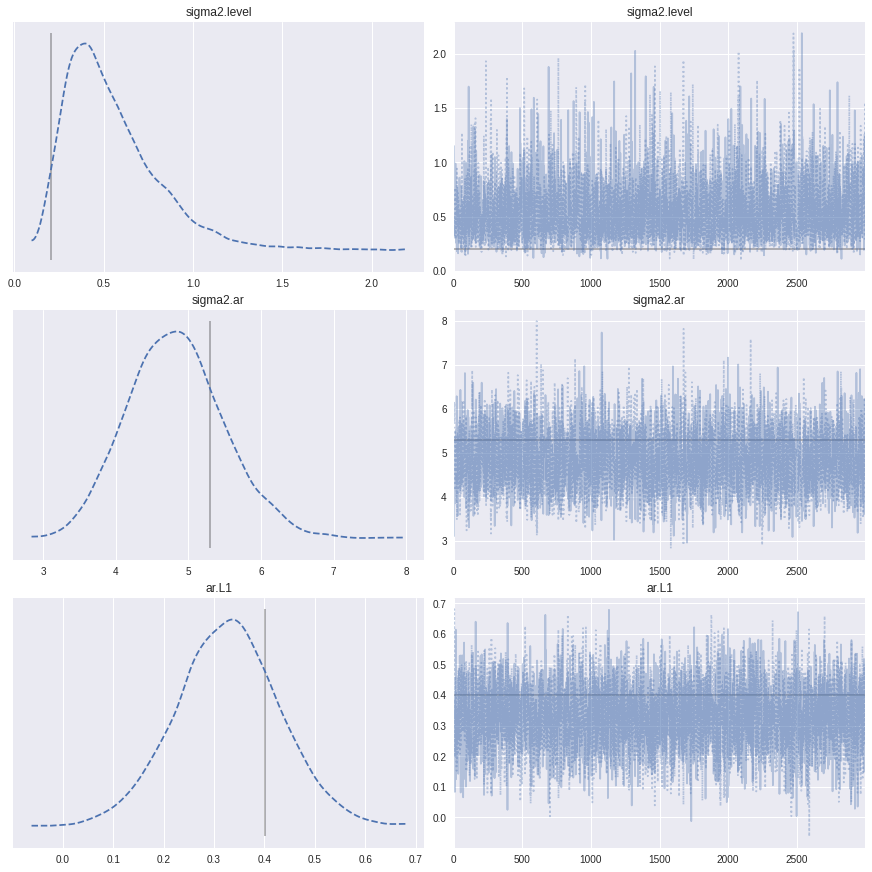

In [16]:
plt.tight_layout()
# Note: the syntax here for the lines argument is required for
# PyMC3 versions >= 3.7
# For version <= 3.6 you can use lines=dict(res_mle.params) instead
_ = pm.plot_trace(
    trace_uc,
    lines=[(k, {}, [v]) for k, v in dict(res_uc_mle.params).items()],
    combined=True,
    figsize=(12, 12),
)

In [17]:
pm.summary(trace_uc)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
sigma2.level,0.545,0.267,0.150,1.019,0.005,0.003,3567.0,3881.0,1.0
sigma2.ar,4.826,0.663,3.671,6.159,0.012,0.008,3185.0,2949.0,1.0
ar.L1,0.327,0.102,0.125,0.515,0.002,0.001,3745.0,3835.0,1.0


In [18]:
# Retrieve the posterior means
params = pm.summary(trace_uc)["mean"].values

# Construct results using these posterior means as parameter values
res_uc_bayes = mod_uc.smooth(params)

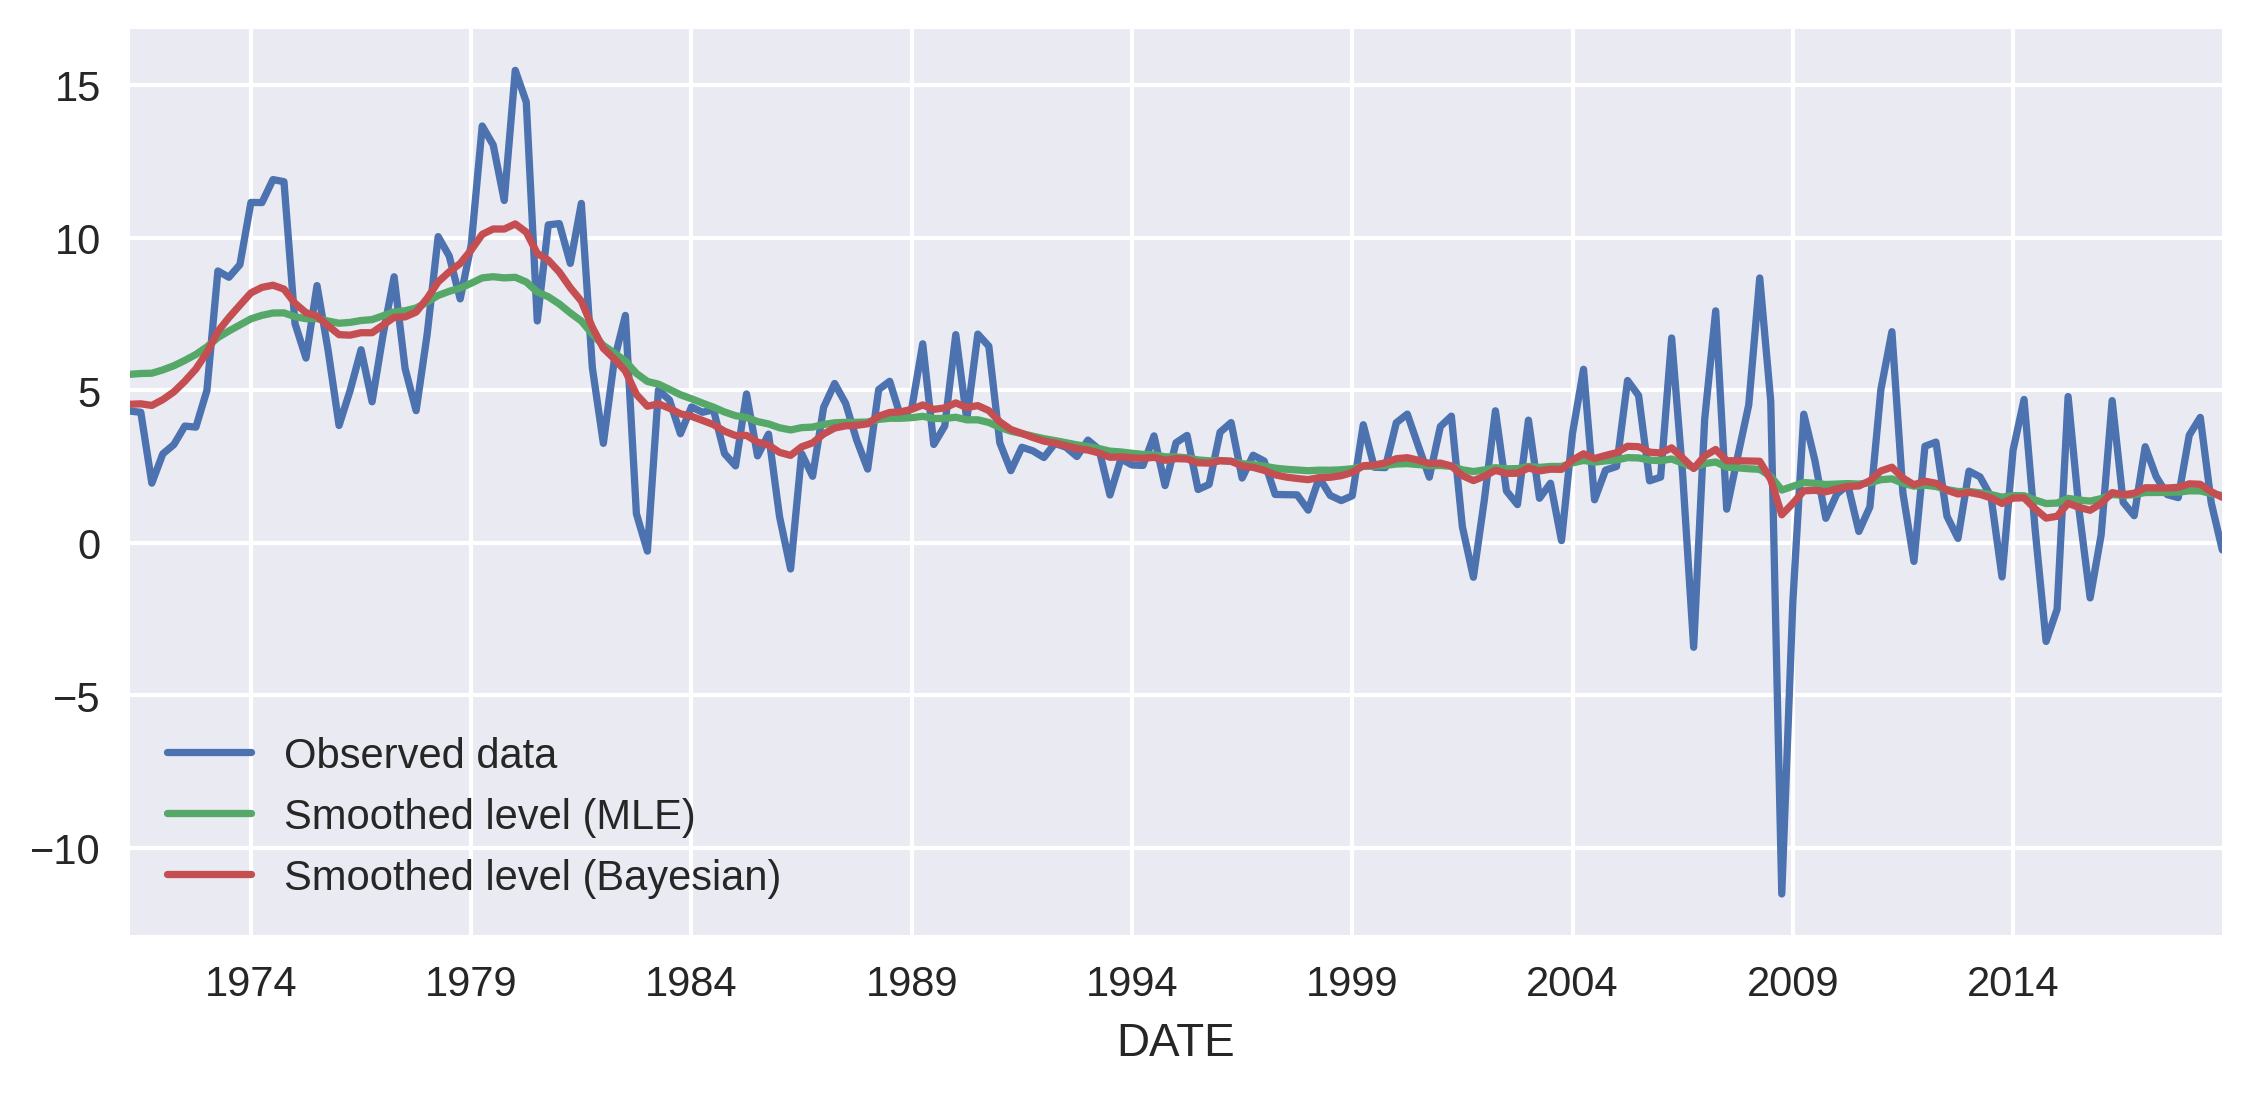

In [19]:
# Graph
fig, ax = plt.subplots(figsize=(9, 4), dpi=300)

# Plot data points
inf["CPIAUCNS"].plot(ax=ax, style="-", label="Observed data")

# Plot estimate of the level term
res_uc_mle.states.smoothed["level"].plot(ax=ax, label="Smoothed level (MLE)")
res_uc_bayes.states.smoothed["level"].plot(ax=ax, label="Smoothed level (Bayesian)")

ax.legend(loc="lower left")